In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import json
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [8]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),  
    'max_depth': hp.quniform('max_depth', 2, 20, 1),  
    'num_leaves': hp.quniform('num_leaves', 20, 300, 10),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),  
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0),  
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),  
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5),  
    'lambda_l1': hp.uniform('lambda_l1', 0, 1),  
    'lambda_l2': hp.uniform('lambda_l2', 0, 1),  
}

In [9]:
n_folds = 3 

def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_fold_train, y_fold_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMClassifier(
            objective='multiclass',
            boosting_type='gbdt',
            num_class=3,
            verbose=-1, 
            n_jobs=-1, 
            **params
        )

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_valid)
        accuracies.append(accuracy_score(y_fold_valid, y_pred))

    mean_accuracy = np.mean(accuracies)

    return {'loss': 1 - mean_accuracy, 'status': STATUS_OK}


In [10]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100, 
            trials=trials)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [1:06:45<00:00, 40.06s/trial, best loss: 0.5062995430701032]
Best hyperparameters: {'bagging_fraction': np.float64(0.8837274787818103), 'feature_fraction': np.float64(0.6253342690722408), 'lambda_l1': np.float64(0.5072607592076765), 'lambda_l2': np.float64(0.3193986309883332), 'learning_rate': np.float64(0.002252648901581115), 'max_depth': np.float64(6.0), 'min_child_samples': np.float64(80.0), 'n_estimators': np.float64(700.0), 'num_leaves': np.float64(40.0)}


In [11]:
for trial in trials.trials:
    print(trial['result']['loss'], trial['misc']['vals'])

0.5124973981757495 {'bagging_fraction': [np.float64(0.7676006601448149)], 'feature_fraction': [np.float64(0.7526447645877914)], 'lambda_l1': [np.float64(0.18497680561969743)], 'lambda_l2': [np.float64(0.7373090779723228)], 'learning_rate': [np.float64(0.001949830420620513)], 'max_depth': [np.float64(12.0)], 'min_child_samples': [np.float64(75.0)], 'n_estimators': [np.float64(1900.0)], 'num_leaves': [np.float64(200.0)]}
0.5131069374546229 {'bagging_fraction': [np.float64(0.7402593024917901)], 'feature_fraction': [np.float64(0.7089886382844681)], 'lambda_l1': [np.float64(0.5983273027985617)], 'lambda_l2': [np.float64(0.5503605535081014)], 'learning_rate': [np.float64(0.0010228592530019166)], 'max_depth': [np.float64(20.0)], 'min_child_samples': [np.float64(70.0)], 'n_estimators': [np.float64(700.0)], 'num_leaves': [np.float64(30.0)]}
0.5367811531285078 {'bagging_fraction': [np.float64(0.6377103766115346)], 'feature_fraction': [np.float64(0.9485063936103877)], 'lambda_l1': [np.float64(0.9

In [12]:
# Convert NumPy types to native Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)  
    elif isinstance(obj, np.floating):
        return float(obj)  
    elif isinstance(obj, list):  
        return [convert_numpy(i) for i in obj]  
    elif isinstance(obj, dict):  
        return {key: convert_numpy(value) for key, value in obj.items()}  
    else:
        return obj

results_with_params = [
    {
        **trial['result'],
        'params': {key: value[0] for key, value in trial['misc']['vals'].items()}
    }
    for trial in trials.trials
]

with open('lgb_model.json', 'w') as f:
    json.dump(results_with_params, f, indent=4)

print('Results stored')


Results stored


In [13]:
with open("lgb_model.json", "r") as f:
    results_with_params = json.load(f)

print("All results:")
for trial in results_with_params:
    print(trial)

All results:
{'loss': 0.5124973981757495, 'status': 'ok', 'params': {'bagging_fraction': 0.7676006601448149, 'feature_fraction': 0.7526447645877914, 'lambda_l1': 0.18497680561969743, 'lambda_l2': 0.7373090779723228, 'learning_rate': 0.001949830420620513, 'max_depth': 12.0, 'min_child_samples': 75.0, 'n_estimators': 1900.0, 'num_leaves': 200.0}}
{'loss': 0.5131069374546229, 'status': 'ok', 'params': {'bagging_fraction': 0.7402593024917901, 'feature_fraction': 0.7089886382844681, 'lambda_l1': 0.5983273027985617, 'lambda_l2': 0.5503605535081014, 'learning_rate': 0.0010228592530019166, 'max_depth': 20.0, 'min_child_samples': 70.0, 'n_estimators': 700.0, 'num_leaves': 30.0}}
{'loss': 0.5367811531285078, 'status': 'ok', 'params': {'bagging_fraction': 0.6377103766115346, 'feature_fraction': 0.9485063936103877, 'lambda_l1': 0.9954059443026895, 'lambda_l2': 0.6103202310520901, 'learning_rate': 0.07131181895106622, 'max_depth': 18.0, 'min_child_samples': 95.0, 'n_estimators': 1100.0, 'num_leaves

In [14]:
print("\nBest trial")
best_trial = min(results_with_params, key=lambda x: x["loss"])
print("Best hyperparameters:", best_trial["params"])
print("Best loss:", best_trial["loss"])


Best trial
Best hyperparameters: {'bagging_fraction': 0.8837274787818103, 'feature_fraction': 0.6253342690722408, 'lambda_l1': 0.5072607592076765, 'lambda_l2': 0.3193986309883332, 'learning_rate': 0.002252648901581115, 'max_depth': 6.0, 'min_child_samples': 80.0, 'n_estimators': 700.0, 'num_leaves': 40.0}
Best loss: 0.5062995430701032


In [15]:
best_trial["params"]['max_depth'] = int(best_trial["params"]['max_depth'])
best_trial["params"]['num_leaves'] = int(best_trial["params"]['num_leaves'])
best_trial["params"]['n_estimators'] = int(best_trial["params"]['n_estimators'])
best_trial["params"]['min_child_samples'] = int(best_trial["params"]['min_child_samples'])

In [16]:
final_model = lgb.LGBMClassifier(
    objective='multiclass', 
    boosting_type='gbdt', 
    num_class=3,
    n_jobs=-1, 
    **best_trial["params"] 
)

final_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.8837274787818103,
               feature_fraction=0.6253342690722408,
               lambda_l1=0.5072607592076765, lambda_l2=0.3193986309883332,
               learning_rate=0.002252648901581115, max_depth=6,
               min_child_samples=80, n_estimators=700, n_jobs=-1, num_class=3,
               num_leaves=40, objective='multiclass')

In [17]:
y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy du modèle optimisé (test) : {final_accuracy * 100:.2f}%")

Accuracy du modèle optimisé (test) : 49.86%


In [18]:
importance_dict = dict(
    zip(
        X_train.columns,
        final_model.feature_importances_   
    )
)

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feat for feat, score in sorted_features[:10]]

X_reduced = train_data[top_features]

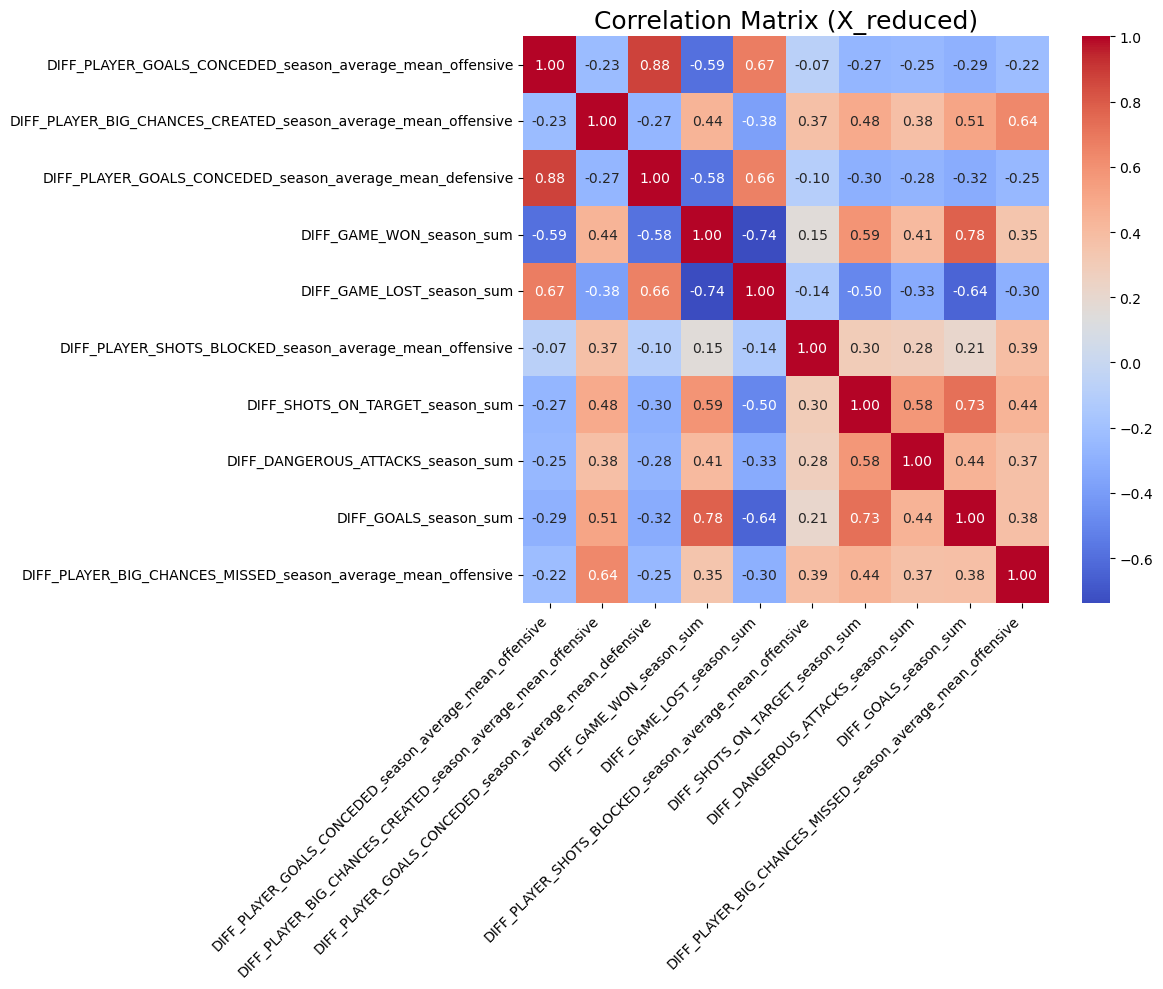

In [19]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

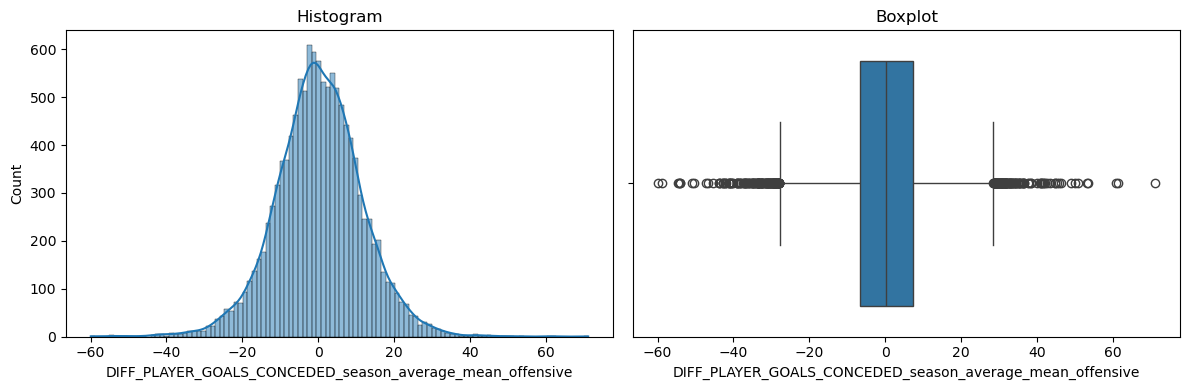

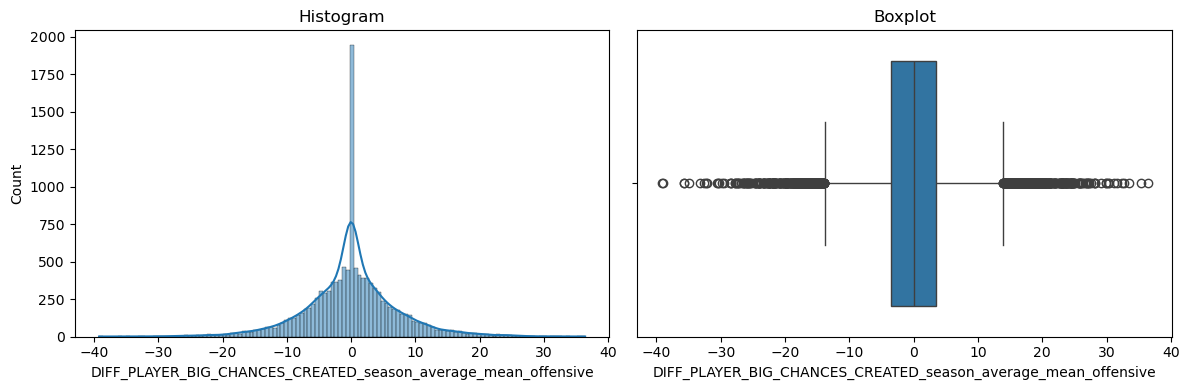

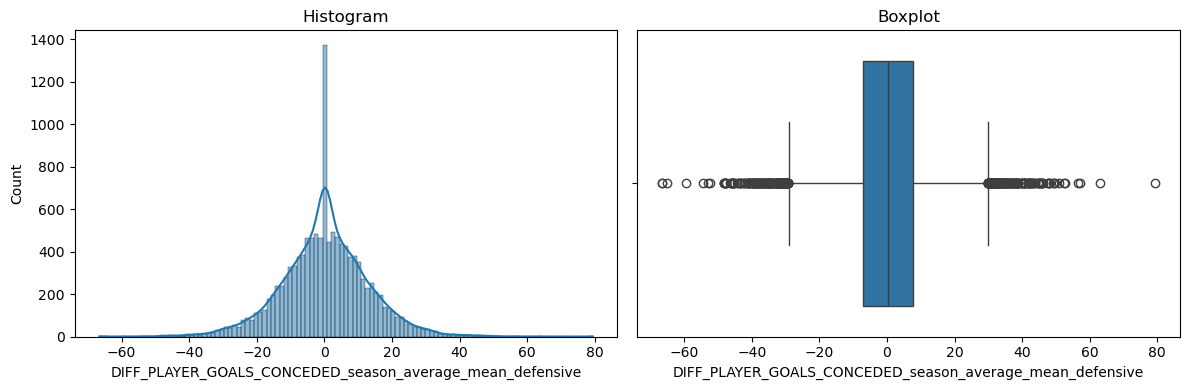

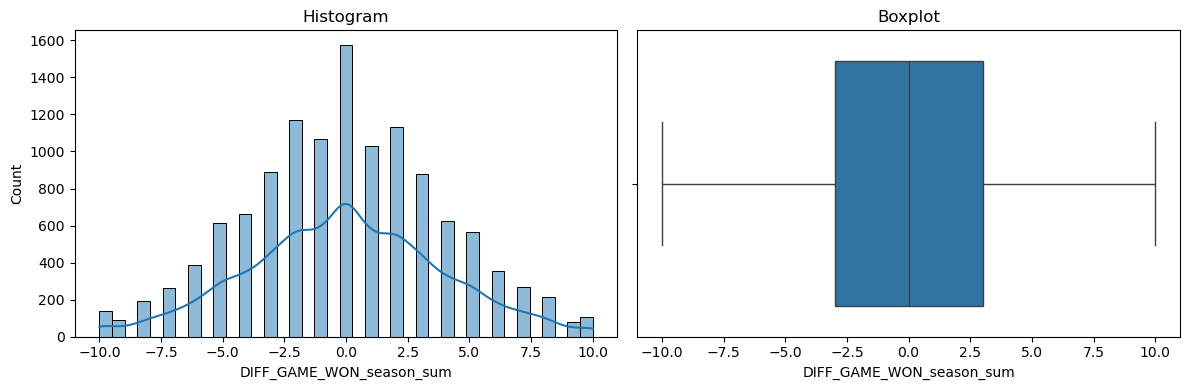

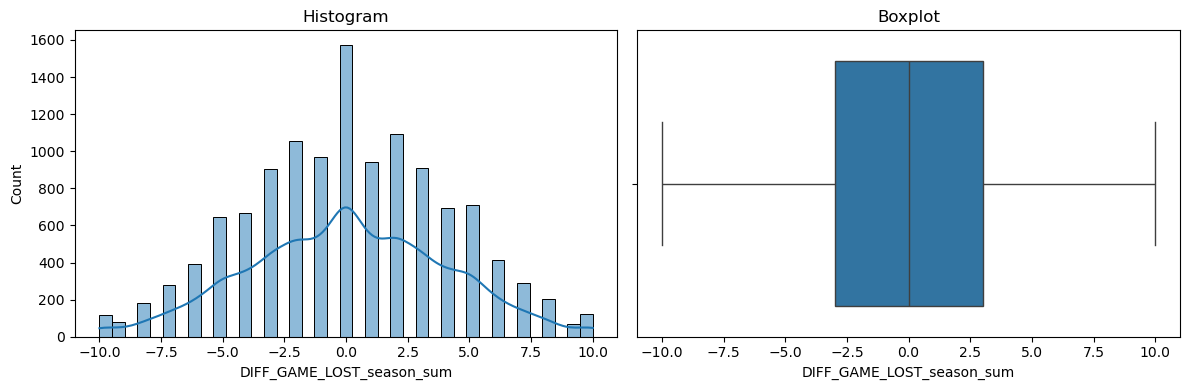

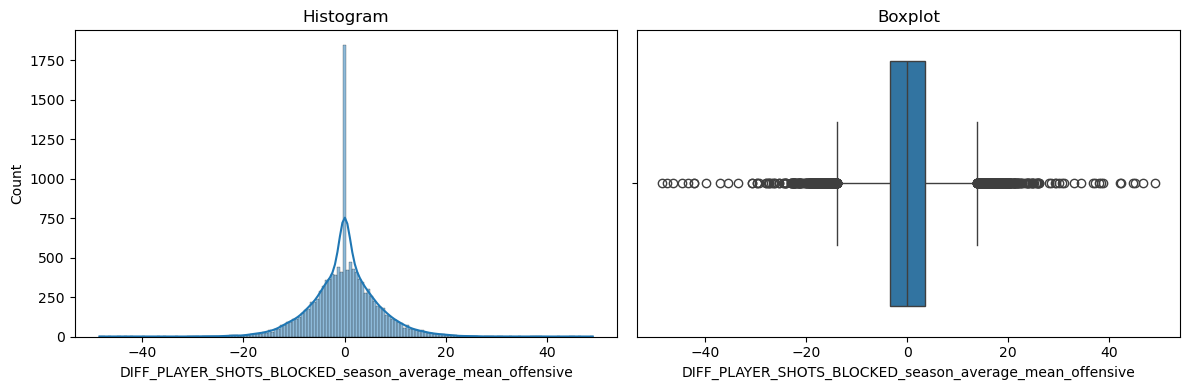

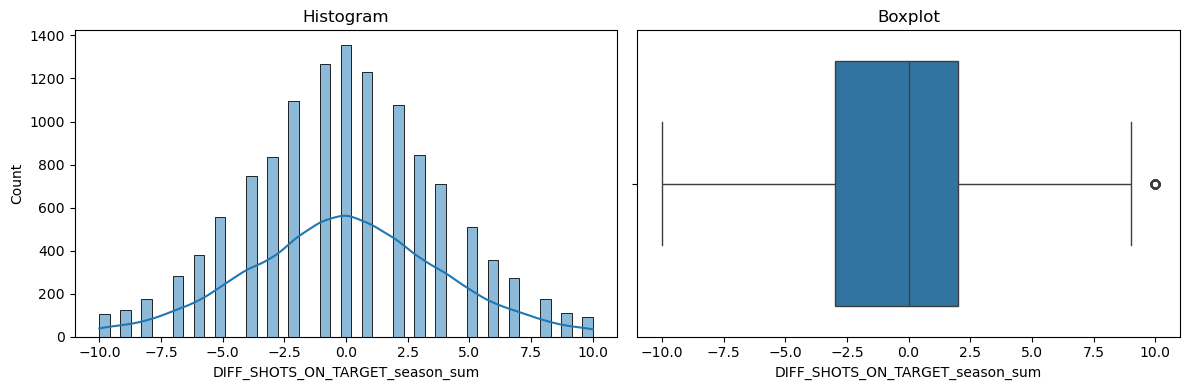

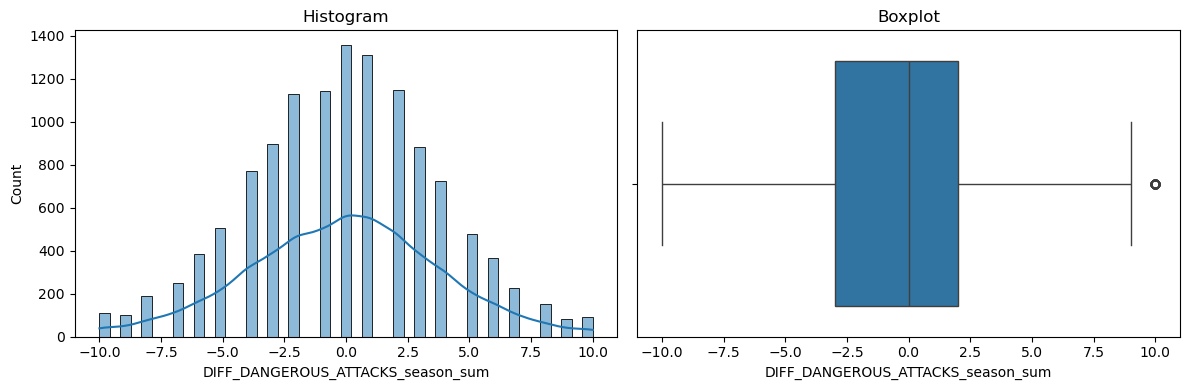

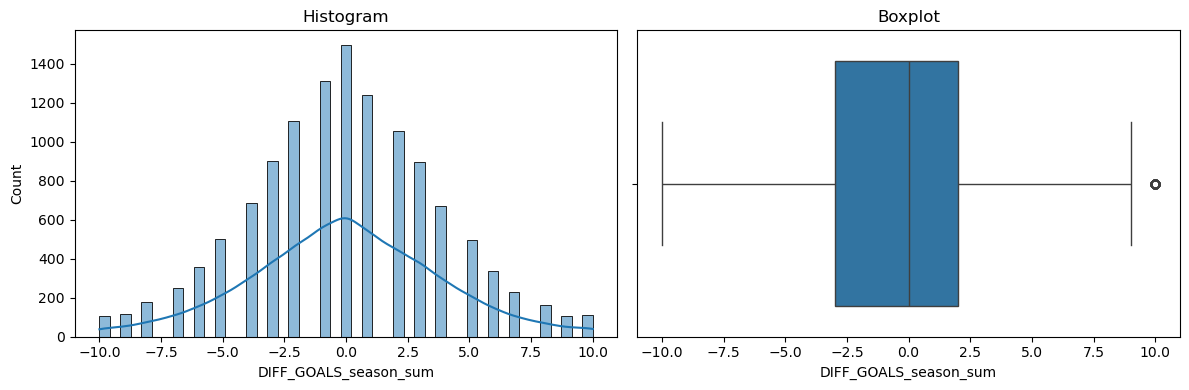

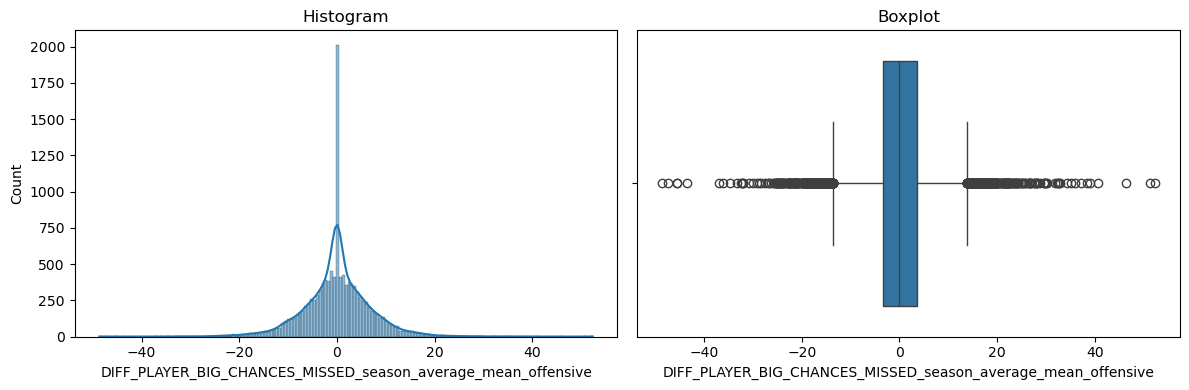

In [20]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)